In [1]:
import sys
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

# Get the absolute path to the src directory
sys.path.append(os.path.abspath("../src"))

from preprocessor import LLMTIMEPreprocessor
from load_qwen import load_qwen_model
from final_model import LoRALinear, process_sequences, evaluate  # assuming final_model.py is in the same directory

import torch
import torch.nn as nn
import numpy as np
import h5py
from torch.utils.data import DataLoader, TensorDataset
from accelerate import Accelerator
from tqdm import tqdm




In [2]:
# 👇 Will work after you've refactored final_model.py
from final_model import train_lora_model

# Train model from notebook with your preferred settings
model, tokenizer, val_loader, val_loss, perplexity = train_lora_model(
    max_steps=2000,  # you can change this to a smaller number for quick tests
    verbose=True
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Training:   0%|          | 0/2000 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training: 100%|██████████| 2000/2000 [1:15:04<00:00,  2.24s/it, loss=0.306]

✅ Training complete. Evaluating...


Training: 100%|██████████| 2000/2000 [1:16:35<00:00,  2.30s/it, loss=0.306]

📊 Validation loss: 0.3338
📈 Perplexity: 1.40


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


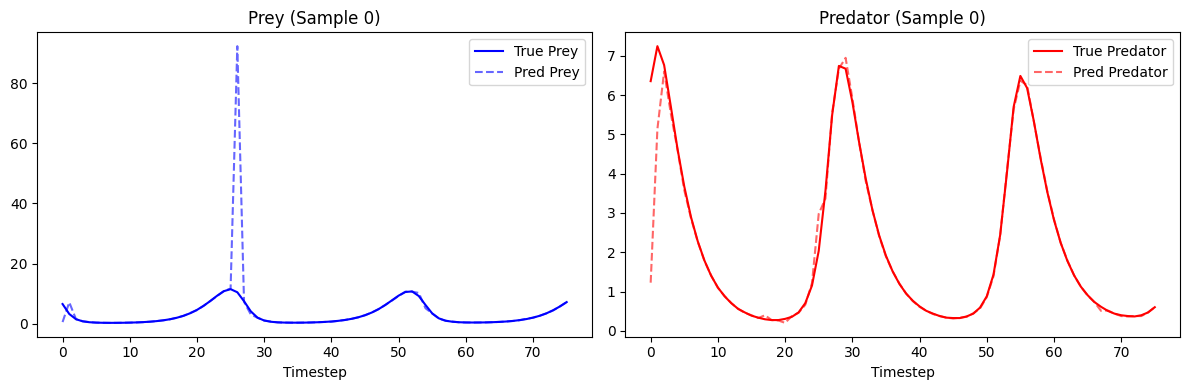

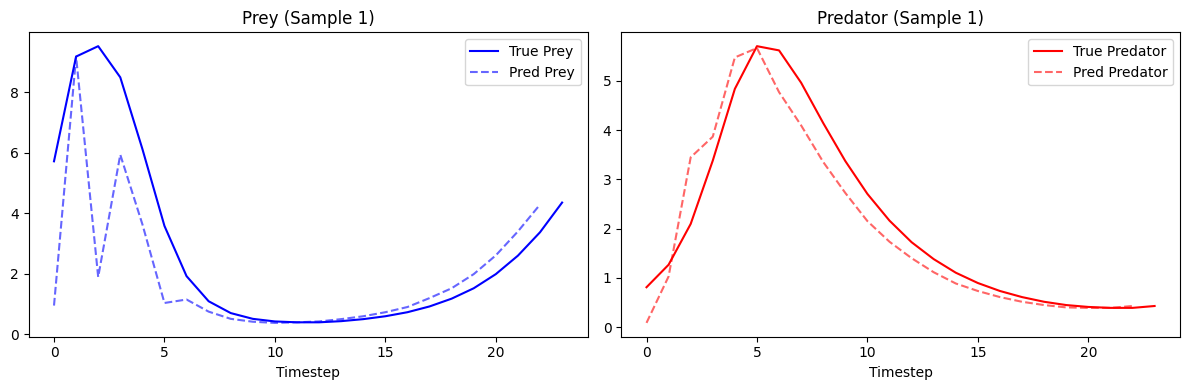

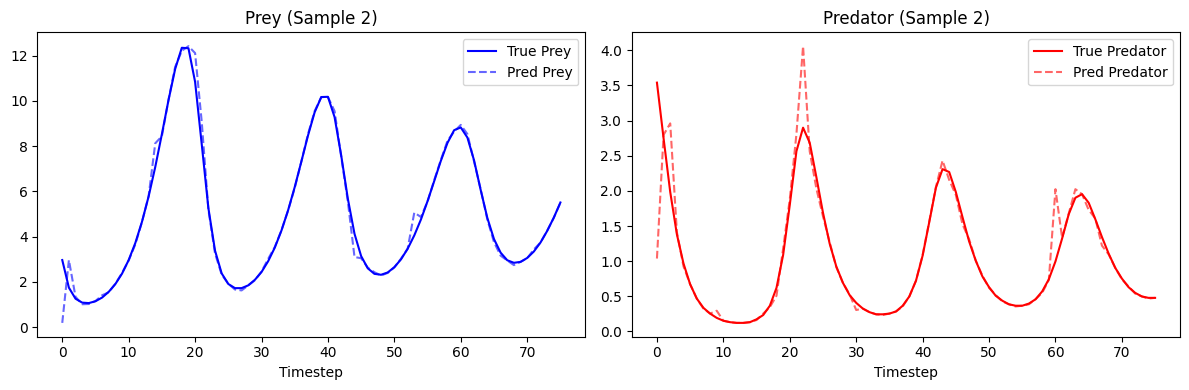

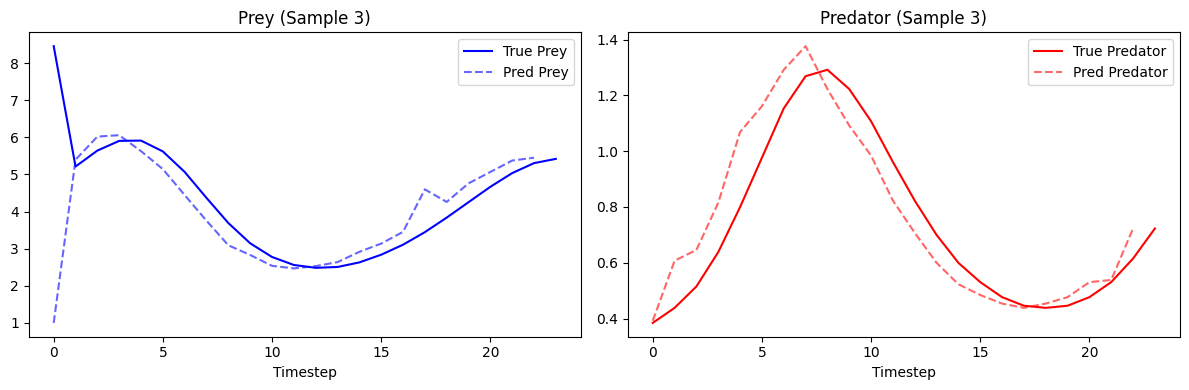

In [3]:
import matplotlib.pyplot as plt
import torch
from transformers import PreTrainedTokenizer
from preprocessor import LLMTIMEPreprocessor

def decode_sequence(input_ids, tokenizer: PreTrainedTokenizer):
    """Decode LLMTIME token sequence to prey/predator float pairs."""
    text = tokenizer.decode(input_ids, skip_special_tokens=True)
    pairs = text.strip().split(";")
    prey, predator = [], []
    for pair in pairs:
        try:
            p, q = map(float, pair.split(","))
            prey.append(p)
            predator.append(q)
        except:
            continue
    return np.array(prey), np.array(predator)

# === Pick one batch from validation loader ===
model.eval()
preprocessor = LLMTIMEPreprocessor()

for (val_batch,) in val_loader:
    val_batch = val_batch.to(model.device)
    with torch.no_grad():
        outputs = model(val_batch)
        preds = torch.argmax(outputs.logits, dim=-1)
    break  # just use the first batch

# === Plot predictions vs ground truth ===
for i in range(min(len(val_batch), 4)):  # plot up to 4 examples
    input_ids = val_batch[i].detach().cpu()
    pred_ids = preds[i].detach().cpu()

    # Decode both
    prey_gt, pred_gt = decode_sequence(input_ids, preprocessor.tokenizer)
    prey_pred, pred_pred = decode_sequence(pred_ids, preprocessor.tokenizer)

    # Apply scale factor if available
    try:
        scale = preprocessor.auto_scale_factor(prey_gt, pred_gt)
        prey_gt *= scale
        pred_gt *= scale
        prey_pred *= scale
        pred_pred *= scale
    except:
        pass

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(prey_gt, label="True Prey", color="blue")
    plt.plot(prey_pred, label="Pred Prey", linestyle="--", color="blue", alpha=0.6)
    plt.title(f"Prey (Sample {i})")
    plt.xlabel("Timestep")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(pred_gt, label="True Predator", color="red")
    plt.plot(pred_pred, label="Pred Predator", linestyle="--", color="red", alpha=0.6)
    plt.title(f"Predator (Sample {i})")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


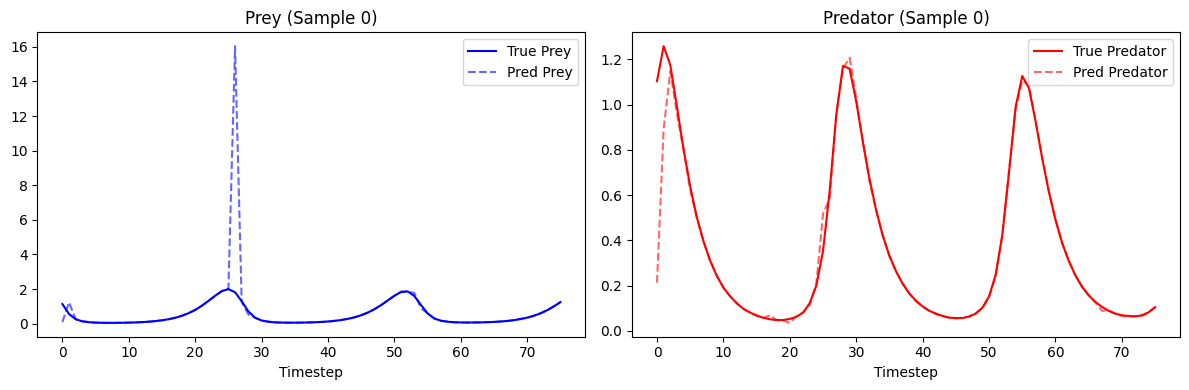

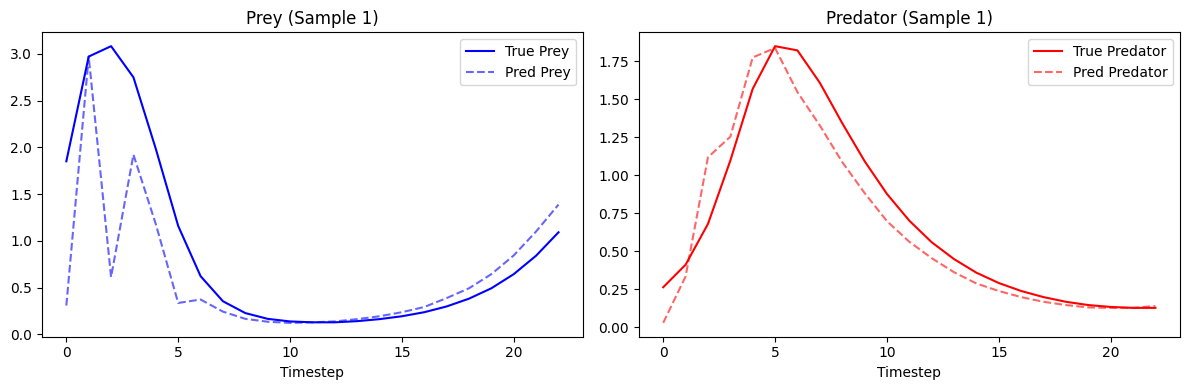

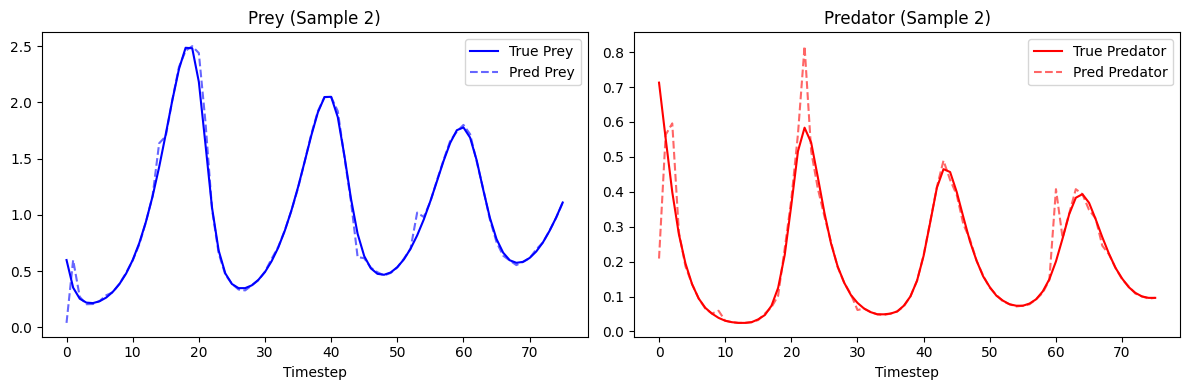

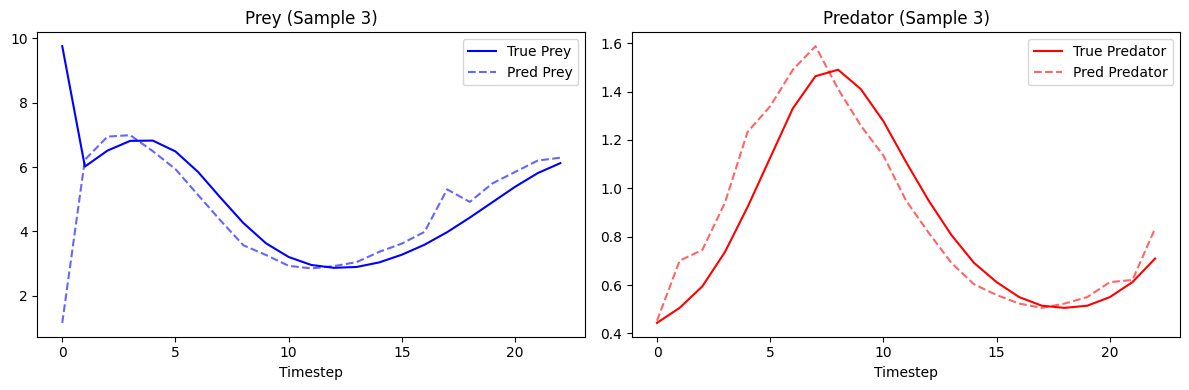

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
from transformers import PreTrainedTokenizer
from preprocessor import LLMTIMEPreprocessor

def decode_sequence(input_ids, tokenizer: PreTrainedTokenizer):
    """Decode LLMTIME token sequence to prey/predator float pairs."""
    text = tokenizer.decode(input_ids, skip_special_tokens=True)
    pairs = text.strip().split(";")
    prey, predator = [], []
    for pair in pairs:
        try:
            p, q = map(float, pair.split(","))
            prey.append(p)
            predator.append(q)
        except:
            continue
    return np.array(prey), np.array(predator)

# === Load raw Lotka-Volterra data to get true scale factor ===
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]  # shape: [N, 100, 2]

prey_data = trajectories[:, :, 0]
predator_data = trajectories[:, :, 1]

# Match the same validation split
num_series = prey_data.shape[0]
input_fraction = 0.7
val_fraction = 0.2

num_train = int(input_fraction * num_series)
num_val = int(val_fraction * num_series)
val_indices = np.arange(num_train, num_train + num_val)

# === Get predictions from one batch ===
model.eval()
preprocessor = LLMTIMEPreprocessor()

for (val_batch,) in val_loader:
    val_batch = val_batch.to(model.device)
    with torch.no_grad():
        outputs = model(val_batch)
        preds = torch.argmax(outputs.logits, dim=-1)
    break  # just one batch

# === Plot predictions vs ground truth ===
for i in range(min(len(val_batch), 4)):  # plot up to 4 examples
    input_ids = val_batch[i].detach().cpu()
    pred_ids = preds[i].detach().cpu()

    # Decode both sequences
    prey_gt, pred_gt = decode_sequence(input_ids, preprocessor.tokenizer)
    prey_pred, pred_pred = decode_sequence(pred_ids, preprocessor.tokenizer)

    # Get the original unscaled values for this sample
    val_index = val_indices[i]  # index into full dataset
    true_prey = prey_data[val_index]
    true_pred = predator_data[val_index]

    # Get the scale factor used during preprocessing
    _, _, scale = preprocessor.preprocess_sample(true_prey, true_pred, num_steps=100)

    # Apply scale to decoded values
    prey_gt *= scale
    pred_gt *= scale
    prey_pred *= scale
    pred_pred *= scale

    # Align lengths for plotting
    min_len = min(len(prey_gt), len(prey_pred))
    timesteps = np.arange(min_len)
    prey_gt = prey_gt[:min_len]
    pred_gt = pred_gt[:min_len]
    prey_pred = prey_pred[:min_len]
    pred_pred = pred_pred[:min_len]

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(timesteps, prey_gt, label="True Prey", color="blue")
    plt.plot(timesteps, prey_pred, label="Pred Prey", linestyle="--", color="blue", alpha=0.6)
    plt.title(f"Prey (Sample {i})")
    plt.xlabel("Timestep")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, pred_gt, label="True Predator", color="red")
    plt.plot(timesteps, pred_pred, label="Pred Predator", linestyle="--", color="red", alpha=0.6)
    plt.title(f"Predator (Sample {i})")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()


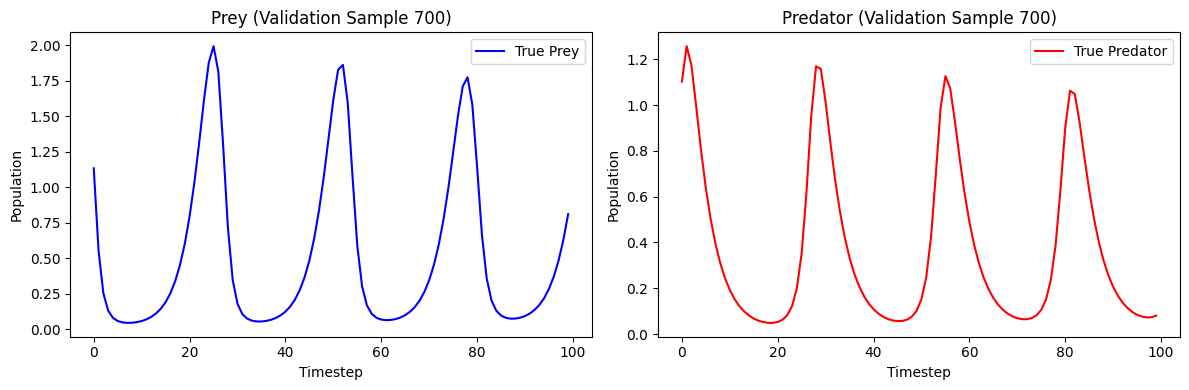

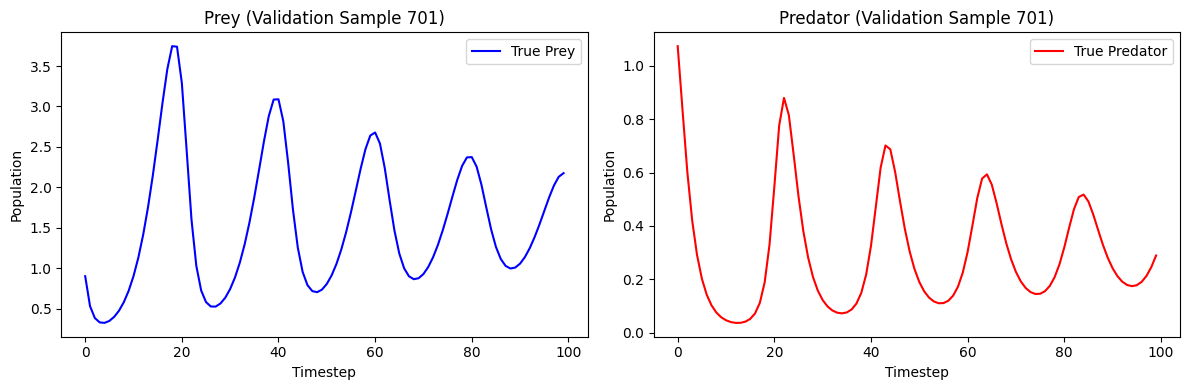

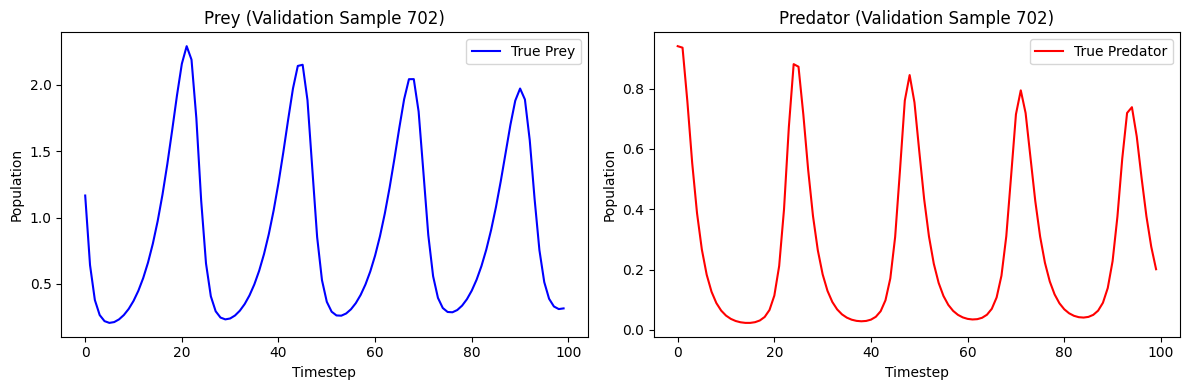

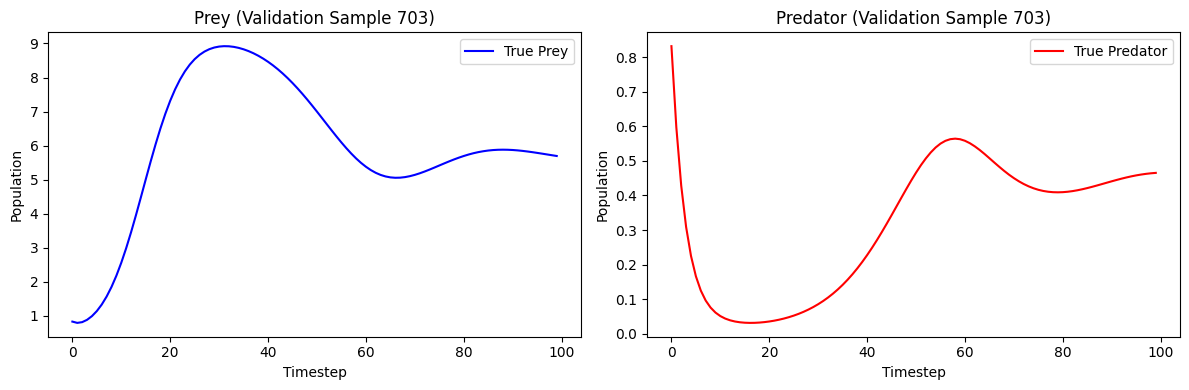

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# === Load raw Lotka-Volterra data ===
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]  # shape: (num_series, 100, 2)

prey_data = trajectories[:, :, 0]
predator_data = trajectories[:, :, 1]

# === Get same validation split as model used ===
num_series = prey_data.shape[0]
input_fraction = 0.7
val_fraction = 0.2

num_train = int(input_fraction * num_series)
num_val = int(val_fraction * num_series)

val_indices = np.arange(num_train, num_train + num_val)

# === Plot actual trajectories from validation set ===
for i, idx in enumerate(val_indices[:4]):
    prey = prey_data[idx]
    predator = predator_data[idx]
    timesteps = np.arange(len(prey))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(timesteps, prey, color="blue", label="True Prey")
    plt.title(f"Prey (Validation Sample {idx})")
    plt.xlabel("Timestep")
    plt.ylabel("Population")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, predator, color="red", label="True Predator")
    plt.title(f"Predator (Validation Sample {idx})")
    plt.xlabel("Timestep")
    plt.ylabel("Population")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [6]:
import torch
import numpy as np
import h5py
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from preprocessor import LLMTIMEPreprocessor
from final_model import process_sequences  # reuse your tokenizer helper


def evaluate_on_test_set(model, tokenizer, data_path="../lotka_volterra_data.h5", batch_size=4, context_length=768):
    model.eval()
    preprocessor = LLMTIMEPreprocessor()

    # === Load raw data ===
    with h5py.File(data_path, "r") as f:
        trajectories = f["trajectories"][:]
    prey = trajectories[:, :, 0]
    predator = trajectories[:, :, 1]

    # === Split into test set ===
    num_series = prey.shape[0]
    num_train = int(0.7 * num_series)
    num_val = int(0.2 * num_series)
    test_indices = np.arange(num_train + num_val, num_series)

    # === Preprocess test data ===
    def prepare_texts(indices):
        texts = []
        for i in indices:
            text, _, _ = preprocessor.preprocess_sample(prey[i], predator[i], num_steps=100)
            texts.append(text)
        return texts

    test_texts = prepare_texts(test_indices)
    test_input_ids = process_sequences(test_texts, tokenizer, max_length=context_length, stride=context_length)
    test_dataset = TensorDataset(test_input_ids)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    all_preds = []
    all_truths = []

    # === Inference ===
    for (batch,) in test_loader:
        batch = batch.to(model.device)
        with torch.no_grad():
            outputs = model(batch)
            preds = torch.argmax(outputs.logits, dim=-1)

        batch = batch.cpu()
        preds = preds.cpu()

        for i in range(len(batch)):
            prey_gt, _ = decode_sequence(batch[i], tokenizer)
            prey_pred, _ = decode_sequence(preds[i], tokenizer)

            # Use only the overlapping region
            min_len = min(len(prey_gt), len(prey_pred))
            if min_len < 10:
                continue  # skip too-short predictions

            all_preds.extend(prey_pred[:min_len])
            all_truths.extend(prey_gt[:min_len])

    # === Metrics ===
    mse = mean_squared_error(all_truths, all_preds)
    mae = mean_absolute_error(all_truths, all_preds)
    r2 = r2_score(all_truths, all_preds)

    print("📊 Test Set Evaluation")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:  {r2:.4f}")

    return mse, mae, r2


In [7]:
mse, mae, r2 = evaluate_on_test_set(model, tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📊 Test Set Evaluation
MSE: 28.2259
MAE: 0.7476
R²:  -0.9449


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


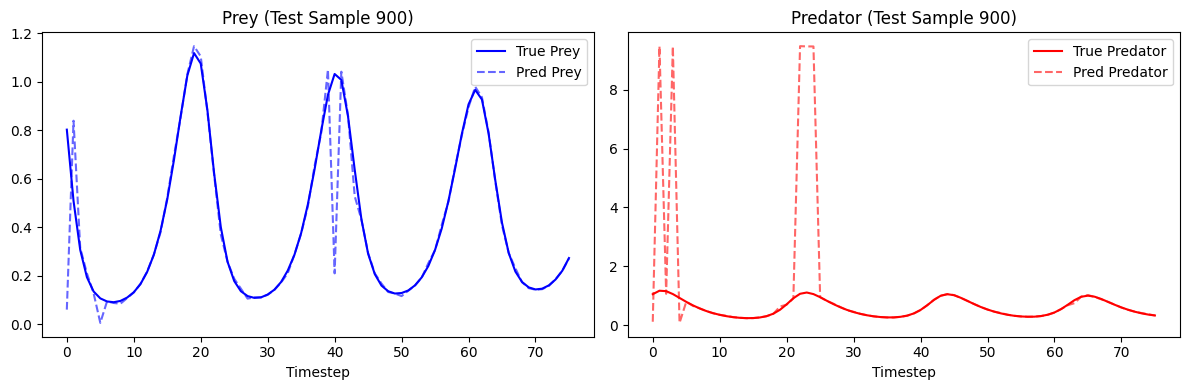

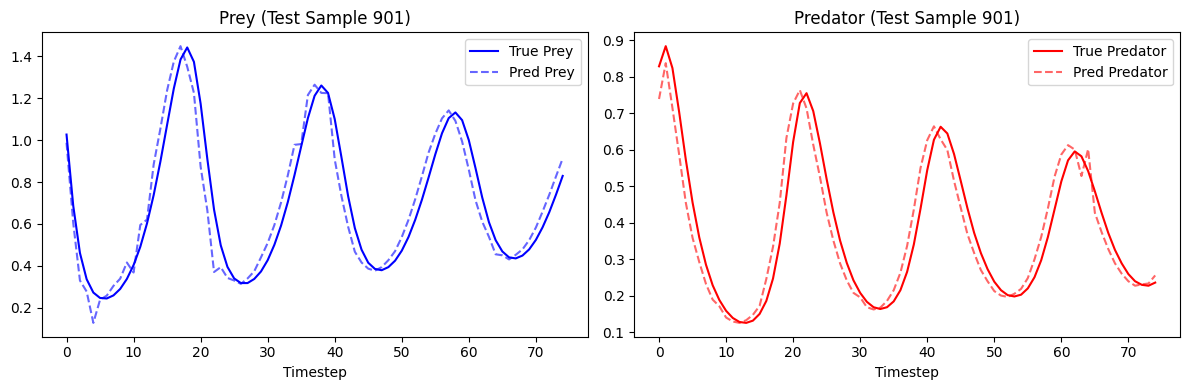

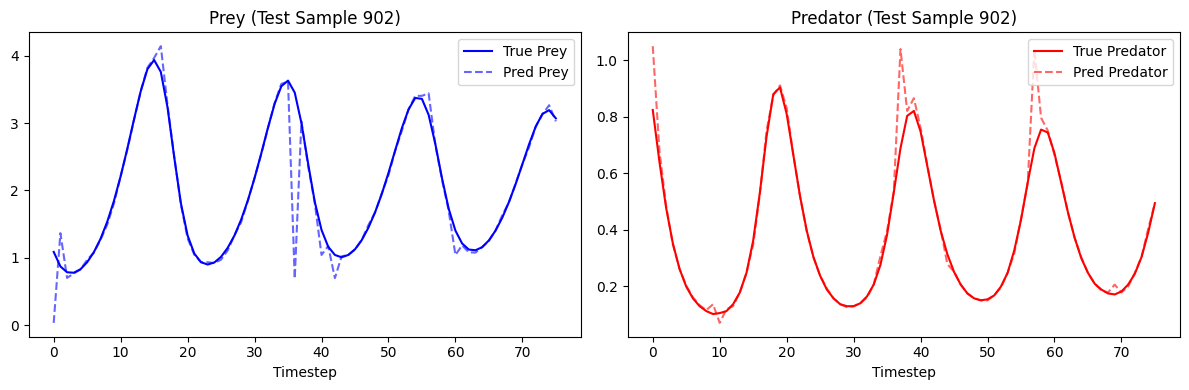

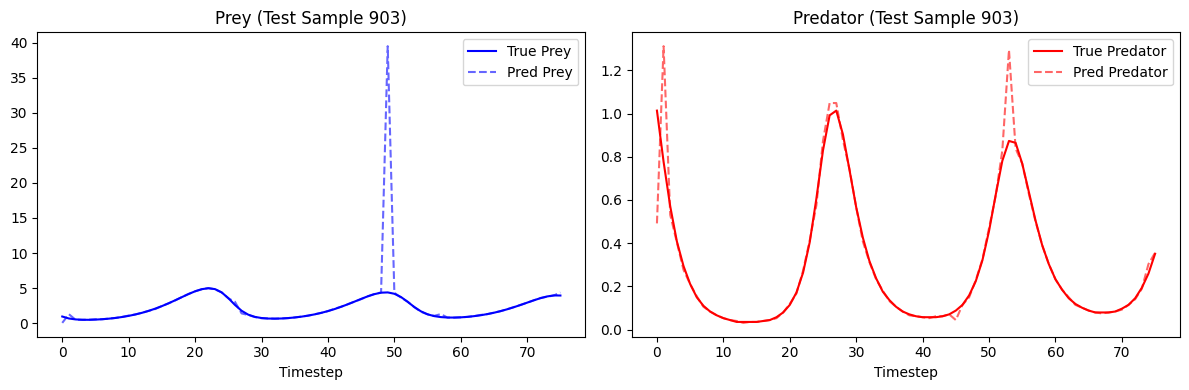

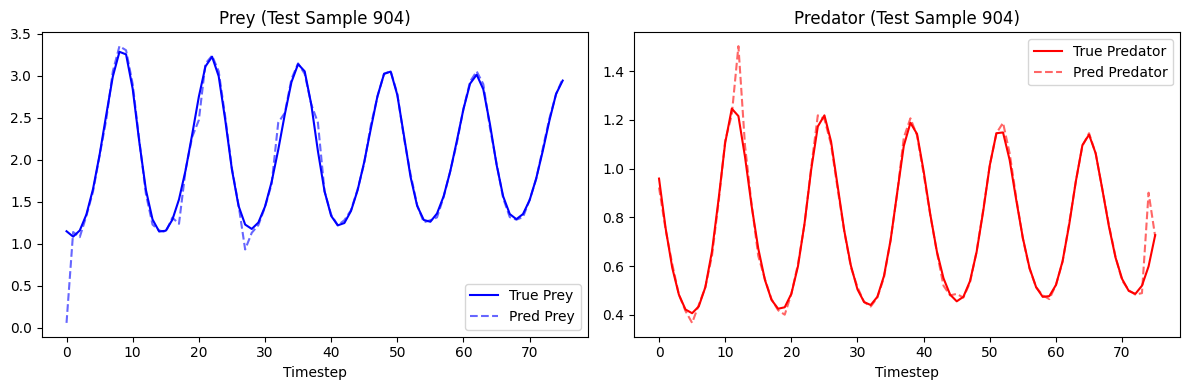

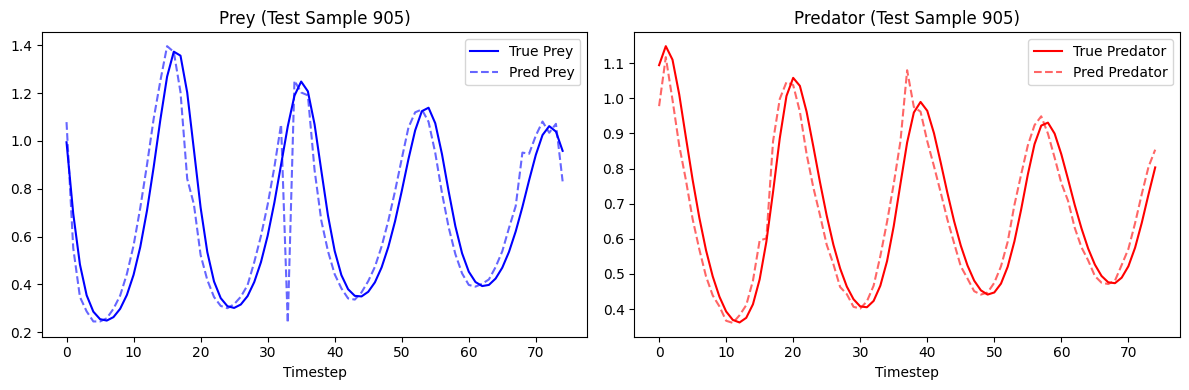

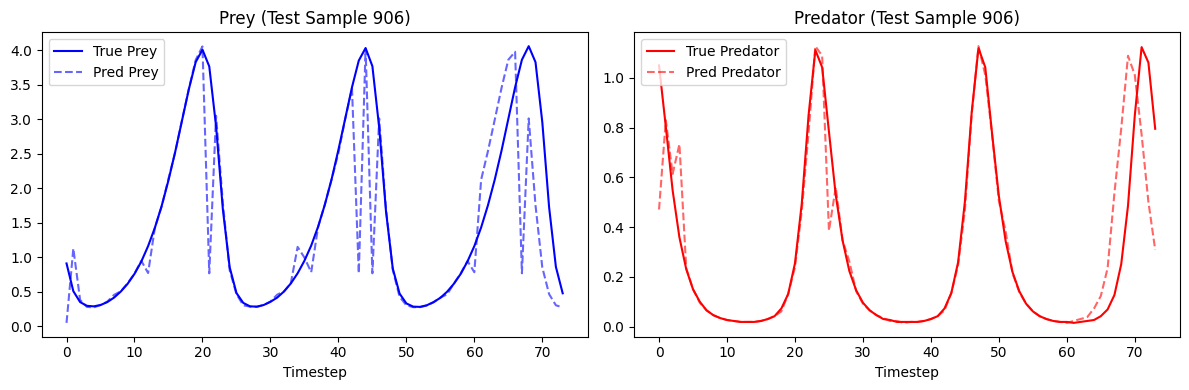

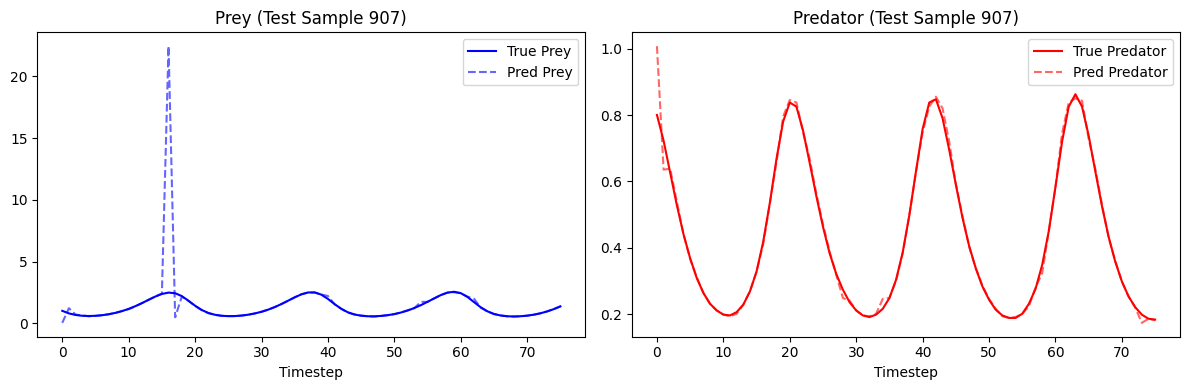

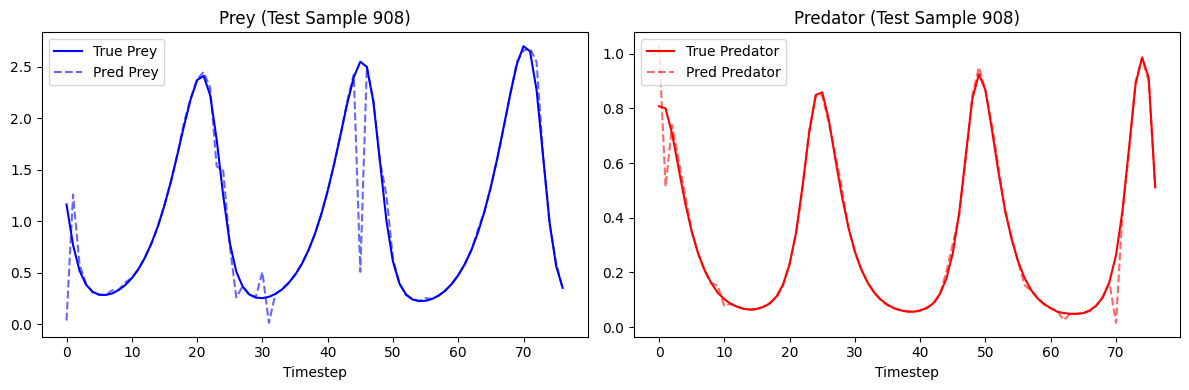

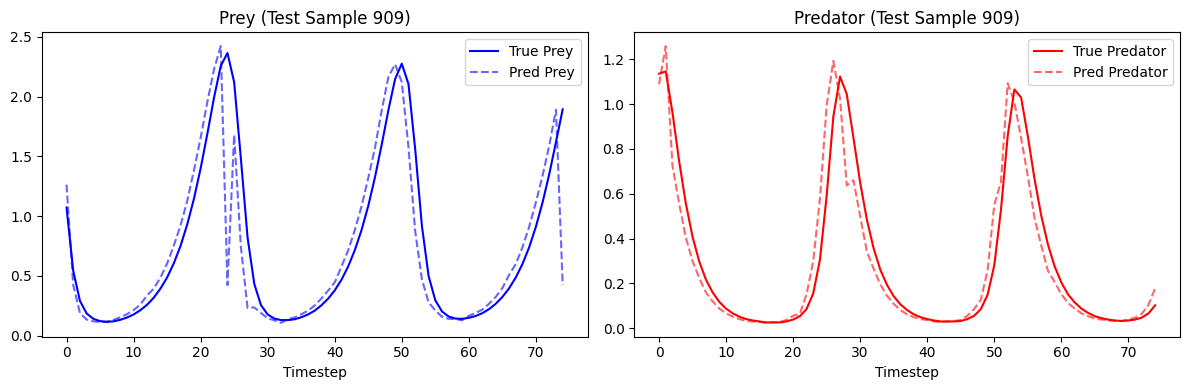

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
from preprocessor import LLMTIMEPreprocessor
from final_model import process_sequences
from transformers import PreTrainedTokenizer


def decode_sequence(input_ids, tokenizer: PreTrainedTokenizer):
    """Decode LLMTIME token sequence to prey/predator float pairs."""
    text = tokenizer.decode(input_ids, skip_special_tokens=True)
    pairs = text.strip().split(";")
    prey, predator = [], []
    for pair in pairs:
        try:
            p, q = map(float, pair.split(","))
            prey.append(p)
            predator.append(q)
        except:
            continue
    return np.array(prey), np.array(predator)


def plot_test_predictions(model, tokenizer, data_path="../lotka_volterra_data.h5", context_length=768):
    model.eval()
    preprocessor = LLMTIMEPreprocessor()

    # === Load data ===
    with h5py.File(data_path, "r") as f:
        trajectories = f["trajectories"][:]  # [N, 100, 2]
    prey_data = trajectories[:, :, 0]
    predator_data = trajectories[:, :, 1]

    # === Get test set indices ===
    num_series = prey_data.shape[0]
    num_train = int(0.7 * num_series)
    num_val = int(0.2 * num_series)
    test_indices = np.arange(num_train + num_val, num_series)

    # === Plot up to 4 examples ===
    for i, idx in enumerate(test_indices[:10]):
        true_prey = prey_data[idx]
        true_pred = predator_data[idx]

        # Get input text and scale
        text, _, scale = preprocessor.preprocess_sample(true_prey, true_pred, num_steps=100)

        input_ids = process_sequences([text], tokenizer, max_length=context_length, stride=context_length)[0]
        input_ids = input_ids.unsqueeze(0).to(model.device)

        with torch.no_grad():
            output = model(input_ids)
            pred_ids = torch.argmax(output.logits, dim=-1)[0].cpu()

        prey_gt, pred_gt = decode_sequence(input_ids[0].cpu(), tokenizer)
        prey_pred, pred_pred = decode_sequence(pred_ids, tokenizer)

        # Rescale all using the original factor
        prey_gt *= scale
        pred_gt *= scale
        prey_pred *= scale
        pred_pred *= scale

        # Align lengths
        min_len = min(len(prey_gt), len(prey_pred))
        timesteps = np.arange(min_len)
        prey_gt = prey_gt[:min_len]
        pred_gt = pred_gt[:min_len]
        prey_pred = prey_pred[:min_len]
        pred_pred = pred_pred[:min_len]

        # Plot
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(timesteps, prey_gt, label="True Prey", color="blue")
        plt.plot(timesteps, prey_pred, label="Pred Prey", linestyle="--", color="blue", alpha=0.6)
        plt.title(f"Prey (Test Sample {idx})")
        plt.xlabel("Timestep")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(timesteps, pred_gt, label="True Predator", color="red")
        plt.plot(timesteps, pred_pred, label="Pred Predator", linestyle="--", color="red", alpha=0.6)
        plt.title(f"Predator (Test Sample {idx})")
        plt.xlabel("Timestep")
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_test_predictions(model, tokenizer)


In [16]:
import torch
import numpy as np
from preprocessor import LLMTIMEPreprocessor
from transformers import PreTrainedTokenizer

def decode_sequence(text, max_steps=100):
    """Decode LLMTIME token string to prey/predator float pairs."""
    pairs = text.strip().split(";")
    prey, predator = [], []
    for pair in pairs[:max_steps]:
        try:
            p, q = map(float, pair.split(","))
            prey.append(p)
            predator.append(q)
        except:
            continue
    return np.array(prey), np.array(predator)

def generate_full_trajectory(model, tokenizer, prey, predator, context_steps=50, total_steps=100, max_new_tokens=512):
    """
    Autoregressively generates the full trajectory using the trained model and tokenizer.

    Args:
        model: Trained Qwen2.5 model with LoRA.
        tokenizer: Corresponding tokenizer.
        prey, predator: np.arrays of shape (100,) for one sample.
        context_steps (int): How many initial steps to condition on.
        total_steps (int): Final trajectory length to decode.
        max_new_tokens (int): How many tokens to generate.

    Returns:
        prey_gt, pred_gt: true full values (length 100)
        prey_pred, pred_pred: predicted values (variable length, up to 100)
    """
    model.eval()
    preprocessor = LLMTIMEPreprocessor()

    # === Step 1: Use first `context_steps` as input ===
    input_text, _, scale = preprocessor.preprocess_sample(prey, predator, num_steps=context_steps)
    input_ids = tokenizer(input_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    # === Step 2: Generate ===
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # deterministic (can change to True + temperature if you want)
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # === Step 3: Decode and parse ===
    full_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    prey_pred, pred_pred = decode_sequence(full_text, max_steps=total_steps)

    # === Step 4: Rescale both prediction and ground truth ===
    prey_pred = prey_pred * scale
    pred_pred = pred_pred * scale

    prey_gt = prey[:total_steps]
    pred_gt = predator[:total_steps]

    return prey_gt, pred_gt, prey_pred, pred_pred

import matplotlib.pyplot as plt
import numpy as np

def plot_generated_trajectory(model, tokenizer, prey, predator, idx=None):
    """
    Uses the model to generate a trajectory and plots true vs predicted values.

    Args:
        model: Trained model.
        tokenizer: Corresponding tokenizer.
        prey, predator: Full trajectory arrays (length 100).
        idx: Optional index to display in the title.
    """
    prey_gt, pred_gt, prey_pred, pred_pred = generate_full_trajectory(model, tokenizer, prey, predator)

    min_len = min(len(prey_pred), len(prey_gt))
    timesteps = np.arange(min_len)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(timesteps, prey_gt[:min_len], label="True Prey", color="blue")
    plt.plot(timesteps, prey_pred[:min_len], label="Pred Prey", linestyle="--", color="blue", alpha=0.6)
    plt.title(f"Prey (Sample {idx})" if idx is not None else "Prey")
    plt.xlabel("Timestep")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, pred_gt[:min_len], label="True Predator", color="red")
    plt.plot(timesteps, pred_pred[:min_len], label="Pred Predator", linestyle="--", color="red", alpha=0.6)
    plt.title(f"Predator (Sample {idx})" if idx is not None else "Predator")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()



In [10]:
idx = 900  # pick a test sample
prey = trajectories[idx, :, 0]
predator = trajectories[idx, :, 1]

prey_gt, pred_gt, prey_pred, pred_pred = generate_full_trajectory(model, tokenizer, prey, predator)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


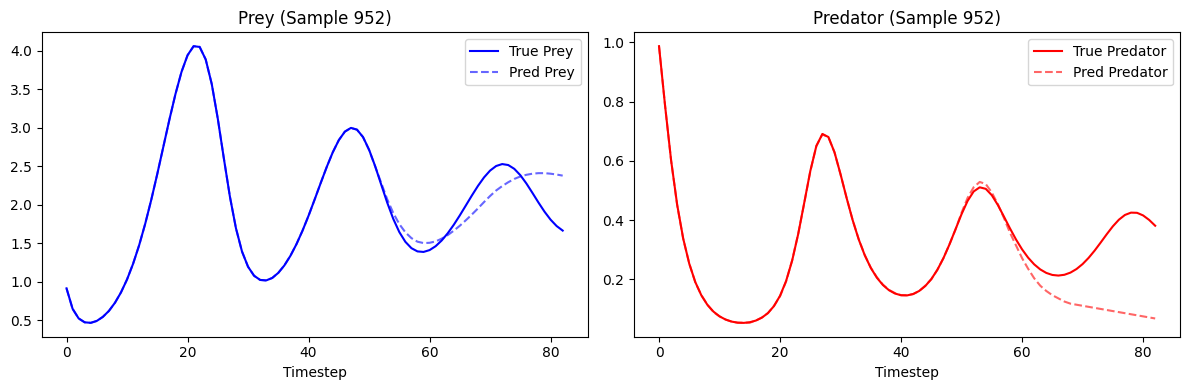

In [17]:
# Load test sample
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]

idx = 952  # choose a test sample
prey = trajectories[idx, :, 0]
predator = trajectories[idx, :, 1]

plot_generated_trajectory(model, tokenizer, prey, predator, idx=idx)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


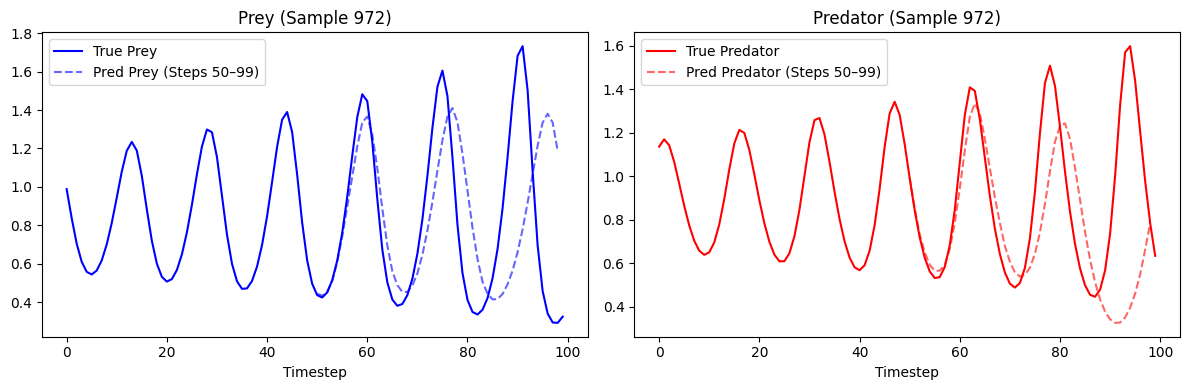

In [23]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
from preprocessor import LLMTIMEPreprocessor
from transformers import PreTrainedTokenizer

def decode_sequence(text, max_steps=100):
    """Decode LLMTIME token string to prey/predator float pairs."""
    pairs = text.strip().split(";")
    prey, predator = [], []
    for pair in pairs[:max_steps]:
        try:
            p, q = map(float, pair.split(","))
            prey.append(p)
            predator.append(q)
        except:
            continue
    return np.array(prey), np.array(predator)

def generate_half_prediction(model, tokenizer, prey, predator, context_steps=50, total_steps=100, max_new_tokens=512):
    """
    Generates the second half of the trajectory given the first half as context.

    Returns:
        prey_gt, pred_gt: true full trajectories (length 100)
        prey_pred, pred_pred: predictions for steps 50–99
    """
    model.eval()
    preprocessor = LLMTIMEPreprocessor()

    # Step 1: Encode context (first 50 steps)
    input_text, _, scale = preprocessor.preprocess_sample(prey, predator, num_steps=context_steps)
    input_ids = tokenizer(input_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    # Step 2: Generate the continuation
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Step 3: Decode only the generated tokens
    gen_only_ids = generated_ids[0][input_ids.shape[-1]:]
    generated_text = tokenizer.decode(gen_only_ids, skip_special_tokens=True)
    gen_prey, gen_pred = decode_sequence(generated_text, max_steps=total_steps - context_steps)

    # Step 4: Rescale predictions
    gen_prey *= scale
    gen_pred *= scale

    # Step 5: Slice ground truth
    prey_gt = prey[:total_steps]
    pred_gt = predator[:total_steps]

    return prey_gt, pred_gt, gen_prey, gen_pred

def plot_second_half_prediction(model, tokenizer, prey, predator, idx=None):
    """
    Plots true full trajectory (steps 0–99) and model prediction only for steps 50–99.
    """
    prey_gt, pred_gt, prey_pred, pred_pred = generate_half_prediction(model, tokenizer, prey, predator)

    t_full = np.arange(len(prey_gt))
    t_pred = np.arange(50, 50 + len(prey_pred))

    plt.figure(figsize=(12, 4))

    # Prey
    plt.subplot(1, 2, 1)
    plt.plot(t_full, prey_gt, label="True Prey", color="blue")
    plt.plot(t_pred, prey_pred, label="Pred Prey (Steps 50–99)", linestyle="--", color="blue", alpha=0.6)
    plt.title(f"Prey (Sample {idx})" if idx is not None else "Prey")
    plt.xlabel("Timestep")
    plt.legend()

    # Predator
    plt.subplot(1, 2, 2)
    plt.plot(t_full, pred_gt, label="True Predator", color="red")
    plt.plot(t_pred, pred_pred, label="Pred Predator (Steps 50–99)", linestyle="--", color="red", alpha=0.6)
    plt.title(f"Predator (Sample {idx})" if idx is not None else "Predator")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()

# === Run Example ===
with h5py.File("../lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]

idx = 972
prey = trajectories[idx, :, 0]
predator = trajectories[idx, :, 1]

plot_second_half_prediction(model, tokenizer, prey, predator, idx=idx)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


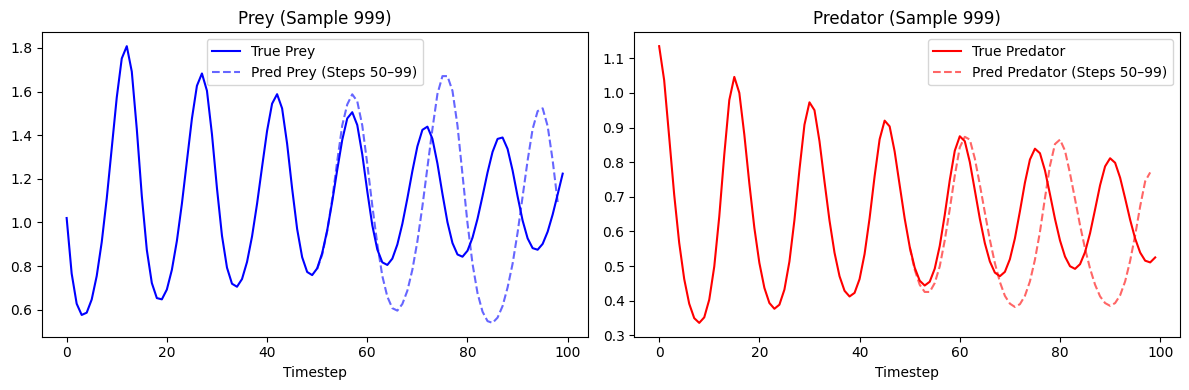

In [24]:
idx = 999
prey = trajectories[idx, :, 0]
predator = trajectories[idx, :, 1]

plot_second_half_prediction(model, tokenizer, prey, predator, idx=idx)